# 🍚 Rice Image Classification: 99% Accuracy with Custom CNN
## 1. Introduction
In this notebook, we aim to classify 5 different rice varieties (Arborio, Basmati, Ipsala, Jasmine, Karacadag) with high precision.

### Project Highlights:

- **Strategy:** We use a Dual T4 GPU setup with MirroredStrategy for efficient parallel training.

- **Data Pipeline:** We implement a controlled data loading mechanism (LIMIT=1500) to balance RAM usage and model performance.

- **Model:** A robust Custom CNN designed from scratch, achieving >99% accuracy.

- **Evaluation:** Comprehensive analysis using Confusion Matrices and Error Visualization to understand model behavior.

## 2. Setup and Library Imports
We import necessary libraries and configure the GPU strategy. We also enable Mixed Precision safely or stick to float32 to avoid numerical instability.

In [1]:
import tensorflow as tf
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, callbacks

# 1. Clear RAM to prevent OOM errors
tf.keras.backend.clear_session()
gc.collect()

# 2. Configure GPU Strategy
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Number of GPUs detected: {strategy.num_replicas_in_sync}')
except:
    strategy = tf.distribute.get_strategy()
    print("Single GPU or CPU is being used.")

2026-02-03 10:53:03.632206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770115983.823533      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770115983.879026      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770115984.366504      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770115984.366543      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770115984.366546      23 computation_placer.cc:177] computation placer alr

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPUs detected: 2


I0000 00:00:1770116000.250375      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770116000.256163      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## 3. Configuration and Constants
We define the dataset path and set the image limit.

- **LIMIT = 1500:** We load 1500 images per class (Total 7,500). This is optimized for Kaggle's RAM.

- **IMG_SIZE:** 224x224 pixels.

In [2]:
# Dataset Path
DATA_DIR = pathlib.Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')

# Hyperparameters
LIMIT = 1500 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

print(f"Target: {LIMIT} images per class (Total: {LIMIT*5})")
print(f"Batch Size: {BATCH_SIZE}")

Target: 1500 images per class (Total: 7500)
Batch Size: 64


## 4. Data Loading (RAM-Safe Method)
We iterate through folders and load images manually using OpenCV to ensure we strictly follow the LIMIT

In [3]:
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
data = []
labels = []

print("Loading data from disk...")

for category in classes:
    path = DATA_DIR / category
    images = list(path.glob('*'))[:LIMIT] 
    
    for img_path in images:
        try:
            img = cv2.imread(str(img_path))
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
            data.append(img)
            labels.append(classes.index(category))
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

X = np.array(data)
y = np.array(labels)

print(f"Data Loaded. Shape: {X.shape}")

Loading data from disk...
Data Loaded. Shape: (7500, 224, 224, 3)


## 5. Data Preprocessing & Pipeline
#### We create the TensorFlow data pipeline.

- **Crucial:** We use drop_remainder=True to prevent "Shape Mismatch" errors during distributed training on dual GPUs.

In [4]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing Function
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Scale to [-1, 1]
    return image, label

# Create TF Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("Pipeline ready.")

Pipeline ready.


## 6. Custom CNN Model Architecture
#### We define a powerful Custom CNN inside the strategy.scope().

- Includes Data Augmentation layers.

- Uses BatchNormalization and Dropout for regularization.

In [5]:
with strategy.scope():
    model = models.Sequential([
        # Input & Augmentation
        layers.Input(shape=IMG_SIZE + (3,)),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.1),
        
        # Conv Block 1
        layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 4
        layers.Conv2D(256, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Classification Head
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(len(classes), activation='softmax', dtype='float32')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,79

 Total params: 457,957 (1.75 MB)

 Trainable params: 456,485 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

## 7. Training Callbacks
Optimization tools to ensure the best results.

In [6]:
callbacks_list = [
    callbacks.ModelCheckpoint("best_rice_model.keras", save_best_only=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
]

## 8. Training the Model
We train for 25 epochs. The ReduceLROnPlateau callback will help us refine the accuracy in later epochs.

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_list
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

I0000 00:00:1770116081.830551      67 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1770116082.670671      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6500 - loss: 0.9061INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - accuracy: 0.6514 - loss: 0.9025 - val_accuracy: 0.1902 - val_loss: 8.7473 - learning_rate: 0.0010
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.8935 - loss: 0.2821 - val_accuracy: 0.1923 - val_loss: 9.2222 - learning_rate: 0.0010
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9127 - loss: 0.2339 - val_accuracy: 0.1923 - val_loss: 7.9617 - learning_rate: 0.0010
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.9150 - loss: 0.2434 - val_accuracy: 0.4029 - val_loss: 3.9742 - learning_rate: 0.0010
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 161

## 9. Basic Evaluation (Accuracy & Loss Curves)
Visualizing the learning process.

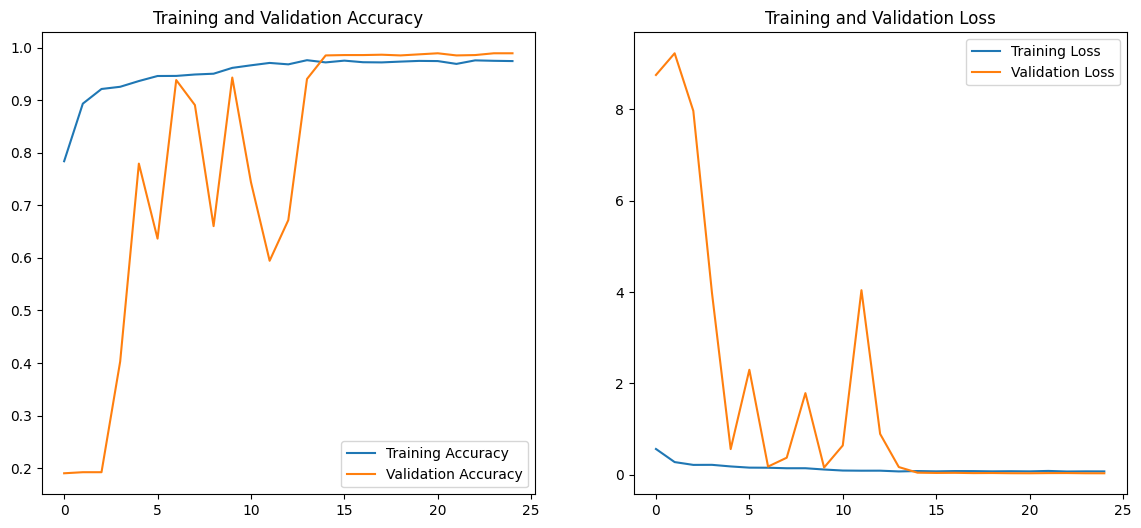

Peak Validation Accuracy: 98.91%


In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

print(f"Peak Validation Accuracy: {max(val_acc)*100:.2f}%")

## 10. Advanced Evaluation: Predictions
We generate predictions for the entire validation set to perform detailed analysis.

In [9]:
# Collect true labels and predictions
y_true = []
y_pred = []
y_prob = []

print("Generating predictions...")
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    y_prob.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)
print("Predictions generated.")

Generating predictions...
Predictions generated.


## 11. Confusion Matrix
Where does the model get confused?

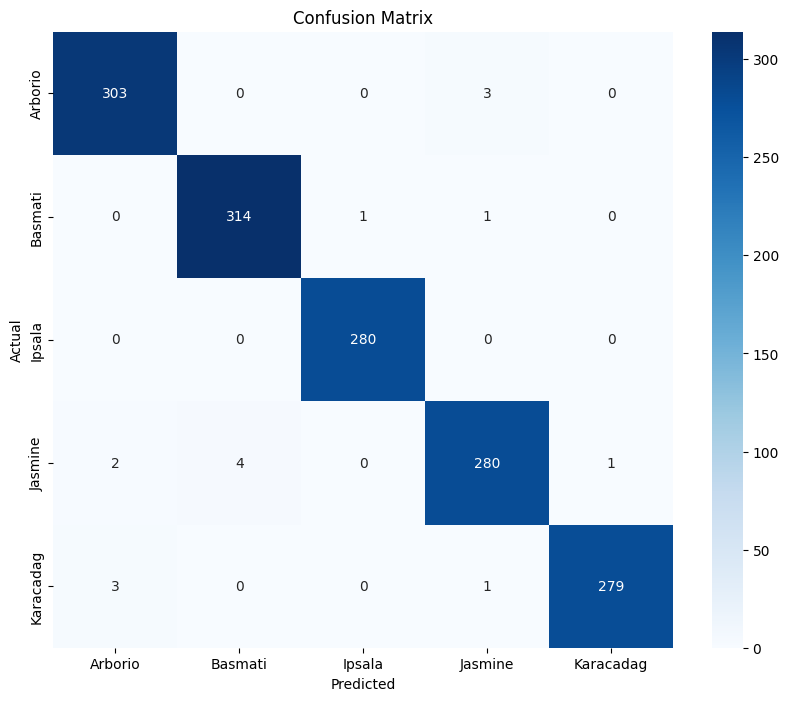

In [10]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 12. Classification Report
Detailed metrics (Precision, Recall, F1-Score) for each rice variety.

In [11]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Arborio       0.98      0.99      0.99       306
     Basmati       0.99      0.99      0.99       316
      Ipsala       1.00      1.00      1.00       280
     Jasmine       0.98      0.98      0.98       287
   Karacadag       1.00      0.99      0.99       283

    accuracy                           0.99      1472
   macro avg       0.99      0.99      0.99      1472
weighted avg       0.99      0.99      0.99      1472



## 13. Visualizing Errors
Let's see the images where the model made a mistake.

Total Errors: 16


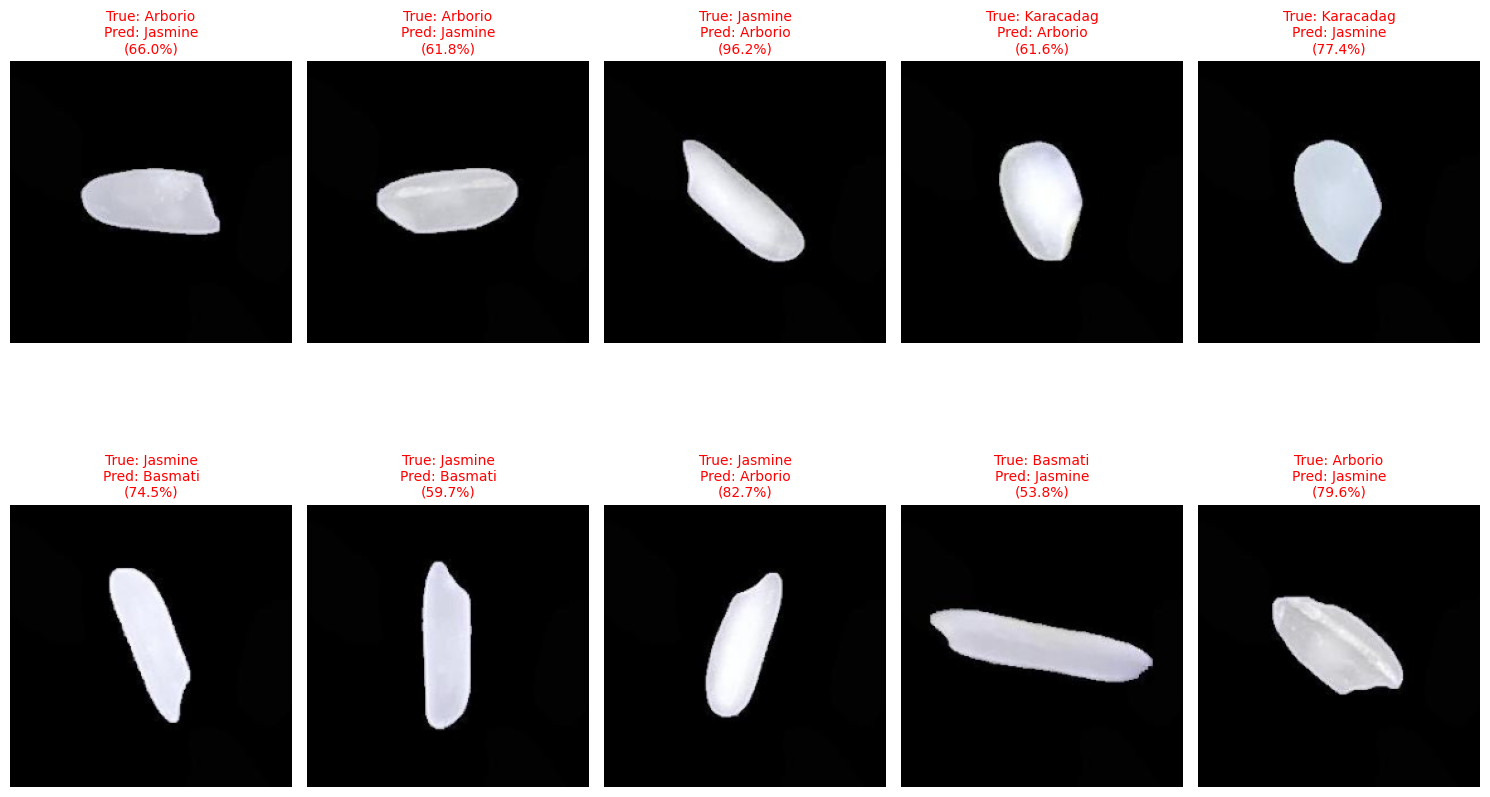

In [12]:
def show_errors(y_true, y_pred, y_prob, dataset, classes, num_errors=10):
    error_indices = np.where(y_true != y_pred)[0]
    print(f"Total Errors: {len(error_indices)}")
    
    if len(error_indices) == 0:
        print("Perfect model! No errors found.")
        return

    # To visualize, we need the original images (taking from numpy array X_val)
    # Since dataset is batched and shuffled, mapping indices back is tricky.
    # We will use X_val directly for visualization simplicity here.
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(error_indices[:num_errors]):
        ax = plt.subplot(2, 5, i + 1)
        
        # Get image from validation set (we used the same seed, but for perfect mapping:
        # It's better to iterate the dataset. Here we use the stored X_val for quick access)
        # Note: X_val is in BGR/RGB uint8 format? No, we loaded it as such.
        # But we need to make sure the indices match the y_true from the dataset iteration.
        # Since 'val_ds' preserves order if not shuffled, and we didn't shuffle val_ds:
        
        img = X_val[idx].astype("uint8")
        plt.imshow(img)
        
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        conf = np.max(y_prob[idx]) * 100
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({conf:.1f}%)", color='red', fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Note: This visualization assumes 'y_true' order matches 'X_val'. 
# Since we created val_ds from tensor_slices(X_val) without shuffling, it should match.
show_errors(y_true, y_pred, y_prob, val_ds, classes)

## 14. Saving the Model
Save the high-performance model for future use.

In [13]:
model.save("rice_classifier_99acc.keras")
print("Model saved successfully.")

Model saved successfully.
